In [ ]:
import soundfile as sf
import resampy
import numpy as np
import matplotlib.pyplot as plt

target_sample_rate = 16000  # Set the sample rate to which you want to downsample.

# Read the audio files and resample them.
signal1, sample_rate1 = sf.read("output4.wav")
signal1_resampled = resampy.resample(signal1, sample_rate1, target_sample_rate)

signal2, sample_rate2 = sf.read("output4/output4/vocals.wav")

signal2_resampled = resampy.resample(signal2[:,0], sample_rate2, target_sample_rate)

# Compute the difference
difference = signal1_resampled - signal2_resampled

# Generate time axis values
time1 = np.linspace(0., len(signal1_resampled)/target_sample_rate, len(signal1_resampled))
time2 = np.linspace(0., len(signal2_resampled)/target_sample_rate, len(signal2_resampled))
time_diff = np.linspace(0., len(difference)/target_sample_rate, len(difference))

plt.figure()

# Plot signal 1
plt.subplot(3, 1, 1)
plt.plot(time1, signal1_resampled)
plt.title("file1.wav")

# Plot signal 2
plt.subplot(3, 1, 2)
plt.plot(time2, signal2_resampled)
plt.title("file2.wav")

# Plot the difference
plt.subplot(3, 1, 3)
plt.plot(time_diff, difference)
plt.title("difference")

plt.tight_layout()
plt.show()

In [ ]:
from spleeter.separator import Separator
import numpy as np
import scipy.signal as sg
import soundfile as sf

# Using embedded configuration.
separator = Separator('spleeter:2stems')

# # Using custom configuration file.

def load_audio(filepath, sr=None, mono=True, dtype='float8'):
    
    x, fs = sf.read(filepath)

    if mono and len(x.shape)>1:
        x = np.mean(x, axis = 1)
    if sr:
        x = sg.resample_poly(x, sr, fs)
        fs = sr 
    x = x.astype(dtype)

    return x, fs

# # Original wav track after spleeter
x, fr = load_audio('output4.wav')
x = np.array(x,ndmin = 2)
x = np.transpose(x)
np.shape(x)

import time


t = time.time()
res = separator.separate(x)
print(time.time() - t)
np.shape(res['vocals'][:,0])
x = np.transpose(x)[0]
x1 = res['vocals'][:,0]
print(np.shape(x), np.shape(x1))
norm_cross_corr = scipy.signal.correlate(x, x1, mode='valid')
norm = np.sqrt(np.sum(x ** 2) * np.sum(x1 ** 2))
if norm != 0:
    norm_cross_corr /= norm
similarity = np.max(np.abs(norm_cross_corr))
print('similarity:', similarity)



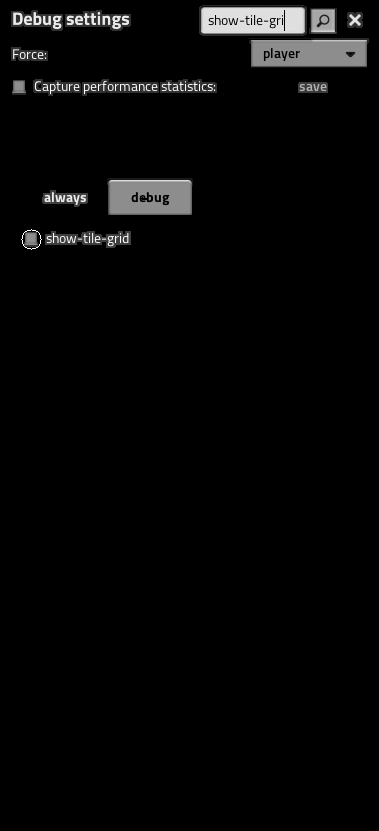

In [13]:
import cv2 as cv
import numpy as np

im = cv.imread('../tmp/test_open_debug_options_im.bmp')

im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
_, mask = cv.threshold(im, 128, 255, cv.THRESH_BINARY)
mask = dilate(mask, 2, cv.MORPH_RECT)
im = cv.bitwise_and(im, im, mask=mask)
ccs = get_ccs(mask, with_br=True)
h, w = mask.shape
p = np.array((0, h))
srt = sorted(ccs, key=lambda x: np.linalg.norm(p - Rect(*x[1]).xy()))
c = Rect(*srt[0][1]).center()
cv.circle(im, c, 10, 255, 1)
dis(im)

In [8]:
'''
this snippet shows how to select belts
'''

import cv2 as cv
import numpy as np
import cv2

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
# import common
from common import *
from sklearn.cluster import KMeans

alpha = 0.001
bg = cv.imread('../tmp/test_get_tooltip1_bg.bmp')
bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)
comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
def get_foreground(bg, comp):
    im = comp.copy()
    # im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    comp = comp.astype(np.float32)
    bg = bg.astype(np.float32)
    fg = (comp - bg)
    fg = np.clip(fg, 0, 255).astype(np.uint8)
    # fg = cv.cvtColor(fg, cv.COLOR_BGR2RGB)
    fg = posterize_blk(fg, 5)
    return fg

fg = get_foreground(bg, comp)
# dis(fg)
vl, hl, mvl, mhl, gw = get_grid(comp, grid_color=(32,32,32))
xy = grid(vl, hl)
# print(xy)
# import itertools
dd = {}
coords = {}


marks = cv.imread('../tmp/test_get_tooltip1_marks.bmp')
marks = cv.cvtColor(marks, cv.COLOR_BGR2GRAY)
ents, ents1 = get_entity_coords_from_marks(marks, comp.astype(np.uint8), grid_color=(32,32,32))

map_c_to_e = {}
for e in ents1:
    map_c_to_e[e.top_left] = e.size
    # print(e.top_left)
#

gw, gh, _ = xy.shape

# for i in range(gw):
    # for j in range(gh):

bmap = np.array([['_'] * gh] * gw)

# print(bmap)
for i, (x, y) in enumerate(itertools.product(vl, hl)):
    # x, y = xy[(i, j)]
    w = 32
    ww = 20

    ii = i // len(vl)    
    jj = i % len(vl)

    c = get_cell_at(fg, (x,y), 32)
    cc = crop_image(c, Rect(w//2-ww//2, w//2-ww//2, ww,ww))
    cnt = np.count_nonzero(cc != (0,0,0))
    if cnt > 32 * 1:
        msk = ((cc != (0,0,0)) * 100).astype(np.uint8)
        # print(i)
        # dis(c, msk)
        rr = Rect(w//2-ww//2,w//2-ww//2, ww, ww)
        cw = crop_image(c, rr)
        dd[i] = [c, cv2.GaussianBlur(cw, (3,3), 0, 0).astype(np.float32)]
        coords[i] = (x, y)
        # putOutlinedText(im, f'{ii}, {jj}', (x+2, y + 16), sz=0.35)
        putOutlinedText(fg, f'{i}', (x+2, y + 16), sz=0.35)
        cf = cw.astype(np.float32)
        cgf = cv.cvtColor(cv.cvtColor(cw, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB).astype(np.float32)
        res = np.clip(cf - cgf, 0, 256).astype(np.uint8)
        _, res = cv.threshold(res, 20, 255, cv.THRESH_BINARY)
        cnt = np.count_nonzero(res)
        # putOutlinedText(im, str(cnt), (x+2, y + 16), sz=0.35)
        h, w, _ = cw.shape
        gr = cv.cvtColor(cw, cv.COLOR_RGB2GRAY)
        # dis(gr)
        cntblk = h * w - cv.countNonZero(gr)
        # cntblk = np.count_nonzero(c)
        cntgry, gmsk = count_gray_pixels1(cw, threshold=20)

        # if (cntgry - cntblk) / (h*w) > 0.68:
        col, cnum = get_prevalent_color(cw)

        ddd = {
            'top-left-ccw': 'tlc',
            'top-left-cw': 'tl',
            'top-right-ccw': 'trc',
            'top-right-cw': 'tr',
            'bottom-left-ccw': 'blc',
            'bottom-left-cw': 'bl',
            'bottom-right-ccw': 'brc',
            'bottom-right-cw': 'br',
            'up': 'u',
            'down': 'd',
            'left': 'l',
            'right': 'r',
            None: 'nnn'
        }

        if col == (25,25,25):
            # putOutlinedText(fg, str(cnum), (x+2, y + 16), sz=0.35)
            if cnum >= 275:
                if (ii, jj) in map_c_to_e:
                    sz = map_c_to_e[(ii, jj)]
                    if sz.tolist() == [1,1]:
                        # cv.circle(fg, (x+16, y+16), 11, (128,128,128), 1)
                        d = classify_image(c)
                        # print(d)
                        if d in map_corner_to_dir:
                            d = corner_to_dir(d)
                        bmap[jj][ii] = d[0]
                        # print(f'{jj},{ii},{d[0]}')
                        putOutlinedText(fg, f'{d[0]}', (x+10, y + 16), sz=0.35)
                        pass
                pass

        # cols = frozenset(tuple(pixel) for row in cw for pixel in row)

        # if len(cols.difference(belt_colors)) < 4:
            # cv.circle(im, (x+16, y+16), 3, (255,0,0), 1)
    # cell_loc()
    # cv.circle(im, (x, y), 3, (255,255,255), 1)


def is_similar(cell_dict, indx1, indx2):

    # assert img1.shape == img2.shape
    # h, w, _ = img1.shape
    # assert w == h
    # img1 = cv2.GaussianBlur(img1, (3,3), 0, 0)
    # img2 = cv2.GaussianBlur(img2, (3,3), 0, 0)
    # img1 = img1.astype(np.float32)
    # img2 = img2.astype(np.float32)
    img1, img2 = cell_dict[indx1][1], cell_dict[indx2][1]

    img11, img22 = cell_dict[indx1][0], cell_dict[indx2][0]

    c1 = frozenset(tuple(pixel) for row in img11 for pixel in row)
    c2 = frozenset(tuple(pixel) for row in img22 for pixel in row)
    # print(sorted(list(c1)))
    # print(sorted(list(c2)))
    max(len(c1), len(c2))
    c3 = c1.union(c2)
    print(len(c3), len(c2), len(c1))

    msk1 = np.clip(img2 - img1, 0, 255).astype(np.uint8)
    _, msk1 = cv.threshold(msk1, 20, 255, cv.THRESH_BINARY)
    cnt1 = np.count_nonzero(msk1)
    msk2 = np.clip(img1 - img2, 0, 255).astype(np.uint8)
    _, msk2 = cv.threshold(msk2, 20, 255, cv.THRESH_BINARY)
    cnt2 = np.count_nonzero(msk2)
#   # print(max(cnt1, cnt2))
    # dis(msk1, msk2, img1.astype(np.uint8), img2.astype(np.uint8))
    h, w, _ = msk2.shape
    diff = max(cnt1, cnt2)
    similar_rate = (h * w - diff) / (h * w)
    # print(similar_rate)


    return similar_rate >= 0.7

lst = [364, 362, 363, 556, 392]
lst = [364, 686, 782]
lst = [685, 686, 717, 718, 781, 782, 813, 814, 422, 364, 432]
# lst = [685, 781]
# lst = [717, 813]
# lst = [686,782]
lst = [718, 814]
lst = [428, 429]
# lst = [166, 171]
# imgs = [dd[idx][0] for idx in lst]


""" for img, idx in zip(imgs, lst):
    print(classify_image(img))
    print(idx)
    dis(img)
    # break
 """

# qwe = [''.join(r) for r in bmap]
# print('\n'.join(qwe))
s = '\n'.join([''.join(row.tolist()) for row in bmap])
    

print(s)
dis(dd[498][1])



___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________
___________________________


TypeError: Cannot handle this data type: (1, 1, 3), <f4

32
[89, 5, 139, 110]
414


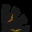

[89, 5, 139, 110]
[89, 5, 139, 110]
________________________
________________________
________________________
_______u________________
_______u__d_dllllll_____
_______u__d_d_____u_____
_______u__d_rrrrrdu_____
_______u__d_dlllllu_____
______rul_d_rrrrrdu_____
______uuu_d______du_____
______uuu_d__lllllu_____
______u_u_d_______u_____
______u_u_rrrrrrrru_____
______u_u_______________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________
________________________


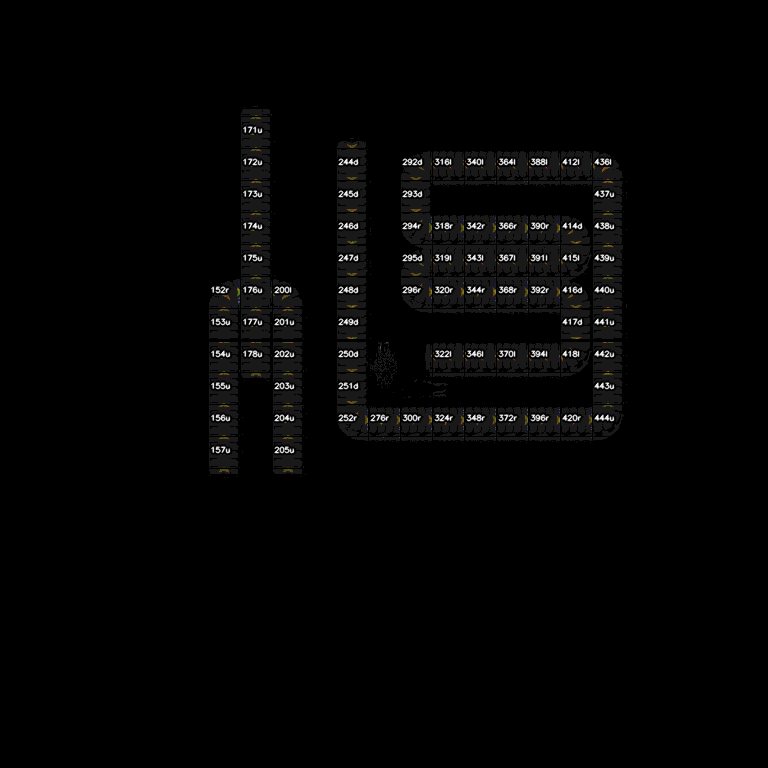

In [63]:
'''
this snippet shows how to select belts
'''

import cv2 as cv
import numpy as np
import cv2

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
import common
from common import *
from npext import *
from sklearn.cluster import KMeans

alpha = 0.001
bg = cv.imread('../tmp/test_get_tooltip1_bg.bmp')
comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)
# dis(comp)
def get_foreground(bg, comp):
    im = comp.copy()
    # im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    comp = comp.astype(np.float32)
    bg = bg.astype(np.float32)
    fg = (comp - bg)
    fg = np.clip(fg, 0, 255).astype(np.uint8)
    # fg = cv.cvtColor(fg, cv.COLOR_BGR2RGB)
    fg = posterize_blk(fg, 5)
    return fg

fg = get_foreground(bg, comp)
# dis(fg)

vl, hl, mvl, mhl, gcw = get_grid(comp, grid_color=(32,32,32))
import itertools
# dis(comp)
print(gcw)

marks = cv.imread('../tmp/test_get_tooltip1_marks.bmp')
marks = cv.cvtColor(marks, cv.COLOR_BGR2GRAY)
ents, ents1 = get_entity_coords_from_marks(marks, comp.astype(np.uint8), grid_color=(32,32,32))

def get_cell_to_entity_map(entities):
    map_c_to_e = {}
    for e in ents1:
        map_c_to_e[e.top_left] = e.size
    return map_c_to_e

def classify_ints(integers):
    def max_dev(integers):
        sorted(integers)
        m = np.mean(integers)
        d = np.abs(integers - m)
        return np.max(d)
    ints = sorted(integers) 
    md3 = max_dev(ints[1:])
    md = max_dev(ints)
    if md3 < 30 and md > 20:
        return 'corner'
    else:
        return 'straight'

def classify_turn(img, iii, iset):
    img = img.astype(np.uint8)
    h, w, _ = img.shape
    ww = 30
    rect = Rect(0, 0, ww, ww)
    cimg = (npext(img) | crop(Rect(w//2 - ww//2, w//2-ww//2, ww,ww))).array
    www = 12
    dd = {
        Rect(rect.x0, rect.y0, www, www): 'top-left',
        Rect(rect.x0 + rect.w - www, rect.y0, www, www): 'top-right',
        Rect(rect.x0, rect.y0 + rect.h - www, www, www): 'bottom-left',
        Rect(rect.x0 + rect.w - www, rect.y0 + rect.h - www, www, www): 'bottom-right'
    }

    def nz_mask(img):
        msk = np.where(np.any(img != (0, 0, 0), axis=-1), 255, 0).astype(np.uint8)
        return msk

    rects = cimg.copy()
    for k, v in dd.items():
        cv.rectangle(rects, k.xy(), np.array(k.xy()) + k.wh(), (255, 0, 0), 1)


    cnts = [cv.countNonZero(nz_mask(crop_image(cimg, k))) for k, v in dd.items()]

    if iii in iset:
        print(cnts)

    if classify_ints(cnts) == 'straight':
        return None, rects, cnts
    else:
        tpl = min(dd.items(), key=lambda tpl: cv.countNonZero(nz_mask(crop_image(cimg, tpl[0]))))
        return tpl[1], rects, cnts

def classify_image(img, iii = None, iset = {}):
    assert len(img.shape) == 3
    w = 32
    t, _, _ = classify_turn(img, iii, iset)
    p = 20
    q = 20 // 4
    def cmp(img, r1, r2, s1, s2):
        i1 = npext(img) | crop(r1) | to_gray() | bin_threshold(60, 255)
        i2 = npext(img) | crop(r2) | to_gray() | bin_threshold(60, 255)
        return s1 if cv.countNonZero(i1.array) < cv.countNonZero(i2.array) else s2
    img_orig = img.copy()     
    if t is None:
        
        # get a subimage of 12x12 size inside original, because on the
        # edges it can contain noise
        ww = 12
        r = Rect(w//2-ww//2, w//2-ww//2, ww, ww)
        img = crop_image(img, r)
        # img_post = posterize_blk(img, 6)
        
        # get most common color and paint it black
        cc, cnt = get_prevalent_color(img)
        # img = img_post
        msk = np.all(img == cc, axis=-1)
        img[msk] = (0, 0, 0)
        
        # flatten image into binary mask, it should coninatin
        # only arrow by which we deduce belt direction
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        _, img = cv.threshold(img, 30, 255, cv.THRESH_BINARY)
        
        contour = find_contour(img)
        if iii in iset:
            dis(img, img_orig)

        # depending on dimensions of arrow bounding box decide
        # the direction of belt
        brect = cv.boundingRect(contour)

        if brect[2] > brect[3]:
            r1 = Rect(w//2 - p//2, 1, p, q-1)
            r2 = Rect(w//2 - p//2, w-q, p, q-1)
            return cmp(img_orig, r1, r2, 'down', 'up')
        else:
            r1 = Rect(1, w//2 - p//2, q-1, p)
            r2 = Rect(w-q, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'right', 'left')
    else:
        if t == 'top-left':
            r1 = Rect(w//2 - p//2, w - q, p, q-1)
            r2 = Rect(w - q, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'top-left-cw', 'top-left-ccw')
        if t == 'top-right':
            r1 = Rect(w//2 - p//2, w - q, p, q-1)
            r2 = Rect(1, w//2 - p//2, q-1, p)
            return cmp(img_orig, r1, r2, 'top-right-ccw', 'top-right-cw')
        if t == 'bottom-right':
            r1 = Rect(1, w//2-p//2, q-1, p)
            r2 = Rect(w//2 - p//2, 1, p, q-1)
            return cmp(img_orig, r1, r2, 'bottom-right-ccw', 'bottom-right-cw')
        if t == 'bottom-left':
            r1 = Rect(w-q, w//2-p//2, q-1, p)
            r2 = Rect(w//2 - p//2, 1, p, q-1)
            return cmp(img_orig, r1, r2, 'bottom-left-cw', 'bottom-left-ccw')

def get_belt_map(vl, hl, gcw, map_c_to_e, fg, iset = {}):
    bmap = np.array([['_'] * len(hl)] * len(vl))
    w, ww = gcw, 20
    rr = Rect(w//2-ww//2,w//2-ww//2, ww, ww)
    for i, (x, y) in enumerate(itertools.product(vl, hl)):
        ii, jj = i // len(hl), i % len(hl)
        
        c = get_cell_at(fg, (x,y), gcw)
        if c.shape != (32, 32, 3):
            continue
        # cv.rectangle(fg, (x,y), (x+32, y+32), (255,0,0), 1)
        cw = crop_image(c, rr)
        if cw.shape != (20, 20, 3):
            continue
        msk = cv.cvtColor(cw, cv.COLOR_RGB2GRAY)
        # cw.emp
        _, msk = cv.threshold(msk, 20, 255, cv.THRESH_BINARY)
        # skip cell if there's no significant pixels
        if cv.countNonZero(msk) < 32 * 1:
            continue
        
        # putOutlinedText(fg, f'{i}', (x, y + 16), sz=0.35)
        col, cnum = get_prevalent_color(cw)
        # skip cell if gray is not prevalent color
        if col != (25,25,25):
            continue
        # skip cell if not enough pixels are gray
        if cnum < 275:
            continue

        # skip cell if it not on cell to entity map
        if (ii, jj) not in map_c_to_e:
            continue
        sz = map_c_to_e[(ii, jj)]
        # skip cell if it corresponds to entity not of 1x1 size
        if sz.tolist() != [1,1]:
            continue

        t, rects, cnts = classify_turn(c, i, iset)
        if i in iset:
            print(i)
            dis(rects, c)
            print(cnts)


        # after all the filtering real cell processing code comes here
        d = classify_image(c, i, iset)
        if d in map_corner_to_dir:
            d = corner_to_dir(d)
        if d is None:
            d = '_'
        bmap[jj][ii] = d[0]
        # t = classify_turn(c)
        # if t is None:
            # d = 'straight'
        # else:
            # d = t
        putOutlinedText(fg, f'{i}{d[0]}', (x+2, y + 16), sz=0.25)
    return bmap

map_c_to_e = get_cell_to_entity_map(ents1)
bmap = get_belt_map(vl, hl, gcw, map_c_to_e, fg, iset={414})


s = '\n'.join([''.join(row.tolist()) for row in bmap])
    
print(s)
dis(fg)



In [6]:
import cv2
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

lbls = dict()

cls = dict()
for i, (idx1, [img1, img1_mod]) in enumerate(dd.items()):
    for j, (idx2, [img2, img2_mod]) in enumerate(dd.items()):
        if i == j:
            continue
        # print(is_similar(dd, idx1, idx2))
        fnd1 = False
        fnd2 = False
        for c, (idx, idxset) in cls.items():
            if is_similar(dd, idx, idx1):
                cls[c][1].add(idx1)
                fnd1 = True

            if is_similar(dd, idx, idx2):
                cls[c][1].add(idx2)
                fnd2 = True
        if not fnd1:
            cc = len(cls)
            cls[cc] = (idx1, {idx1})
        if not fnd2:
            cc = len(cls)
            cls[cc] = (idx2, {idx2})

# dis()
# for cc, (img, imgsn) in cls.items():
    # print(cc)
    # imgs = [images[ii] for ii in imgsn]
    # dis(*imgs)


In [19]:
import cv2 as cv
import numpy as np

im = cv.imread('../tmp/test_get_tooltip1_fg.bmp')
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

gr = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

comp = cv.imread('../tmp/test_get_tooltip1_comp.bmp')
comp = cv.cvtColor(comp, cv.COLOR_BGR2RGB)
get_grid(comp, grid_color=(32,32,32))
print(gr.ndim)
# dis(comp)

2


In [105]:
def build_graph_from_map(bmap: str):

    bmap = bmap.strip('\n \t').split('\n')
    moves = {
        'u': (-1, 0),
        'd': (1, 0),
        'r': (0, 1),
        'l': (0, -1),
        '_': (0, 0)
    }

    allowed_moves = {
        'u': ('l', 'r', 'u'),
        'd': ('l', 'r', 'd'),
        'r': ('r', 'd', 'u'),
        'l': ('l', 'd', 'u'),
    }

    def is_valid(x, y):
        return 0 <= x < len(bmap) and 0 <= y < len(bmap[0]) and bmap[x][y] != '_'

    graph = {}
    for i in range(len(bmap)):
        for j in range(len(bmap[0])):
            if bmap[i][j] == '_':
                continue
            graph[(i, j)] = []
            i_, j_ = moves[bmap[i][j]]
            i1 = i + i_
            j1 = j + j_
            if not is_valid(i1, j1):
                continue
            if bmap[i1][j1] in allowed_moves[bmap[i][j]]:
                graph[(i,j)].append((i1, j1))


    return graph

def find_all_paths(graph):
    def dfs(node, path):
        # Append current node to the path
        path.append(node)
        
        # Check if the node has no outgoing edges (i.e., end of path)
        if node not in graph or not graph[node]:
            all_paths.append(path.copy())
        else:
            for next_node in graph[node]:
                dfs(next_node, path)
        
        # Remove the current node to backtrack
        path.pop()

    all_paths = []
    
    # Call DFS from each node that is not in the middle of a path
    # A node is a start node if it does not appear as a destination in the graph
    start_nodes = set(graph.keys()) - {node for edges in graph.values() for node in edges}
    for start_node in start_nodes:
        dfs(start_node, [])

    # Filter out subpaths
    non_subpaths = []
    
    for path in all_paths:
        is_subpath = False
        for other_path in all_paths:
            if path != other_path and path == other_path[:len(path)]:
                is_subpath = True
                break
        if not is_subpath:
            non_subpaths.append(path)
    
    return non_subpaths

def collapse_paths(smap, paths):
    smap = smap.strip('\n \t').split('\n')
    out = []
    for path in paths:
        out1 = [path[0]]
        pp = path[0]
        cnt = 1
        for p in path[1:]:
            a = smap[p[0]][p[1]]
            b = smap[pp[0]][pp[1]]
            if a != b:
                cnt = 1
                pp = p
                out1.append(p)
            else:
                cnt += 1
        if cnt > 1:
            out1.append(path[-1])
        out.append(out1)
    return out

# Example usage
smap = '''
___u___
___u___
__ru___
__uu___
__uu___
'''

graph = build_graph_from_map(smap)
paths = find_all_paths(graph)
rr = collapse_paths(smap, paths)
print(rr)


[[(4, 2), (2, 2), (2, 3), (0, 3)], [(4, 3), (0, 3)]]


In [4]:
import cv2 as cv
import numpy as np
import cv2

import sys
from pathlib import Path

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))
from common import *
import common
from npext import *

gr = cv2.imread('../tmp/test_get_tooltip1_gr.bmp')
fg = cv2.imread('../tmp/test_get_tooltip1_fg.bmp')

im = npext(gr) | bgr2rgb()

# dis(gr.array)

UFuncTypeError: Cannot cast ufunc 'bitwise_or' output from dtype('O') to dtype('uint8') with casting rule 'same_kind'